**Proyecto Aprendizaje Profundo**

Reconocimiento de Facturas y Certificaciones Bancarias

**1.   Análisis de datos**

Para iniciar se debe cargar el archivo Documentos_fcp.zip, debe cargar el archivo Img_prediccion_page-0001.jpg

In [1]:
# limpiamos rastros del dataset
!rm -rf /tmp/documentos_fcp*
# descomprimimos
!unzip /content/Documentos_fcp.zip -d /tmp/

Archive:  /content/Documentos_fcp.zip
   creating: /tmp/Documentos_fcp/cert/
  inflating: /tmp/Documentos_fcp/cert/cert.1.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.10.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.11.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.12.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.13.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.14.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.15.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.16.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.17.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.18.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.19.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.2.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.20.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.21.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.22.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.23.jpg  
  inflating: /tmp/Documentos_fcp/cert/cert.24.jpg  
  inflating: /tmp/Documentos_fcp/cert/cer

Importamos las blibliotecas TensorFlow 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
data_dir = "/tmp/Documentos_fcp/"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

80


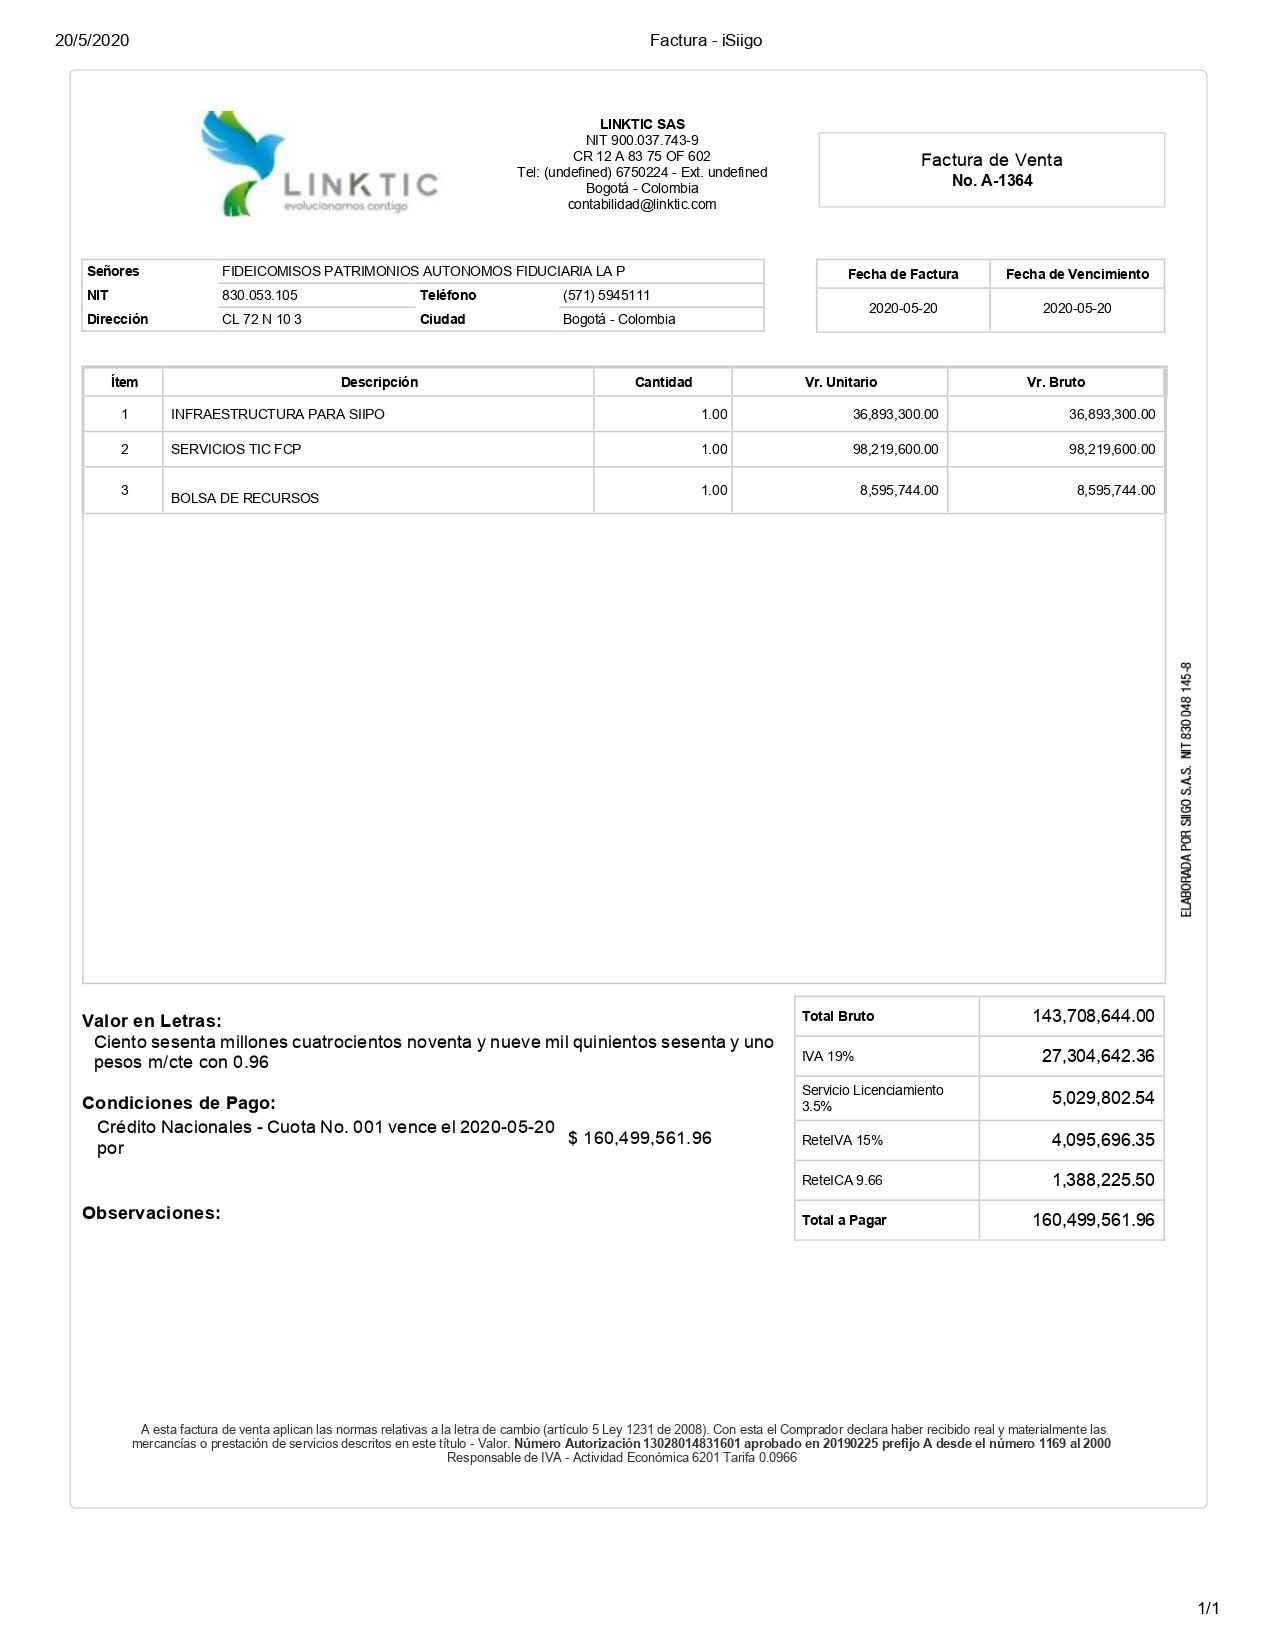

In [ ]:
facturas = list(data_dir.glob('fact/*'))
PIL.Image.open(str(facturas[0]))

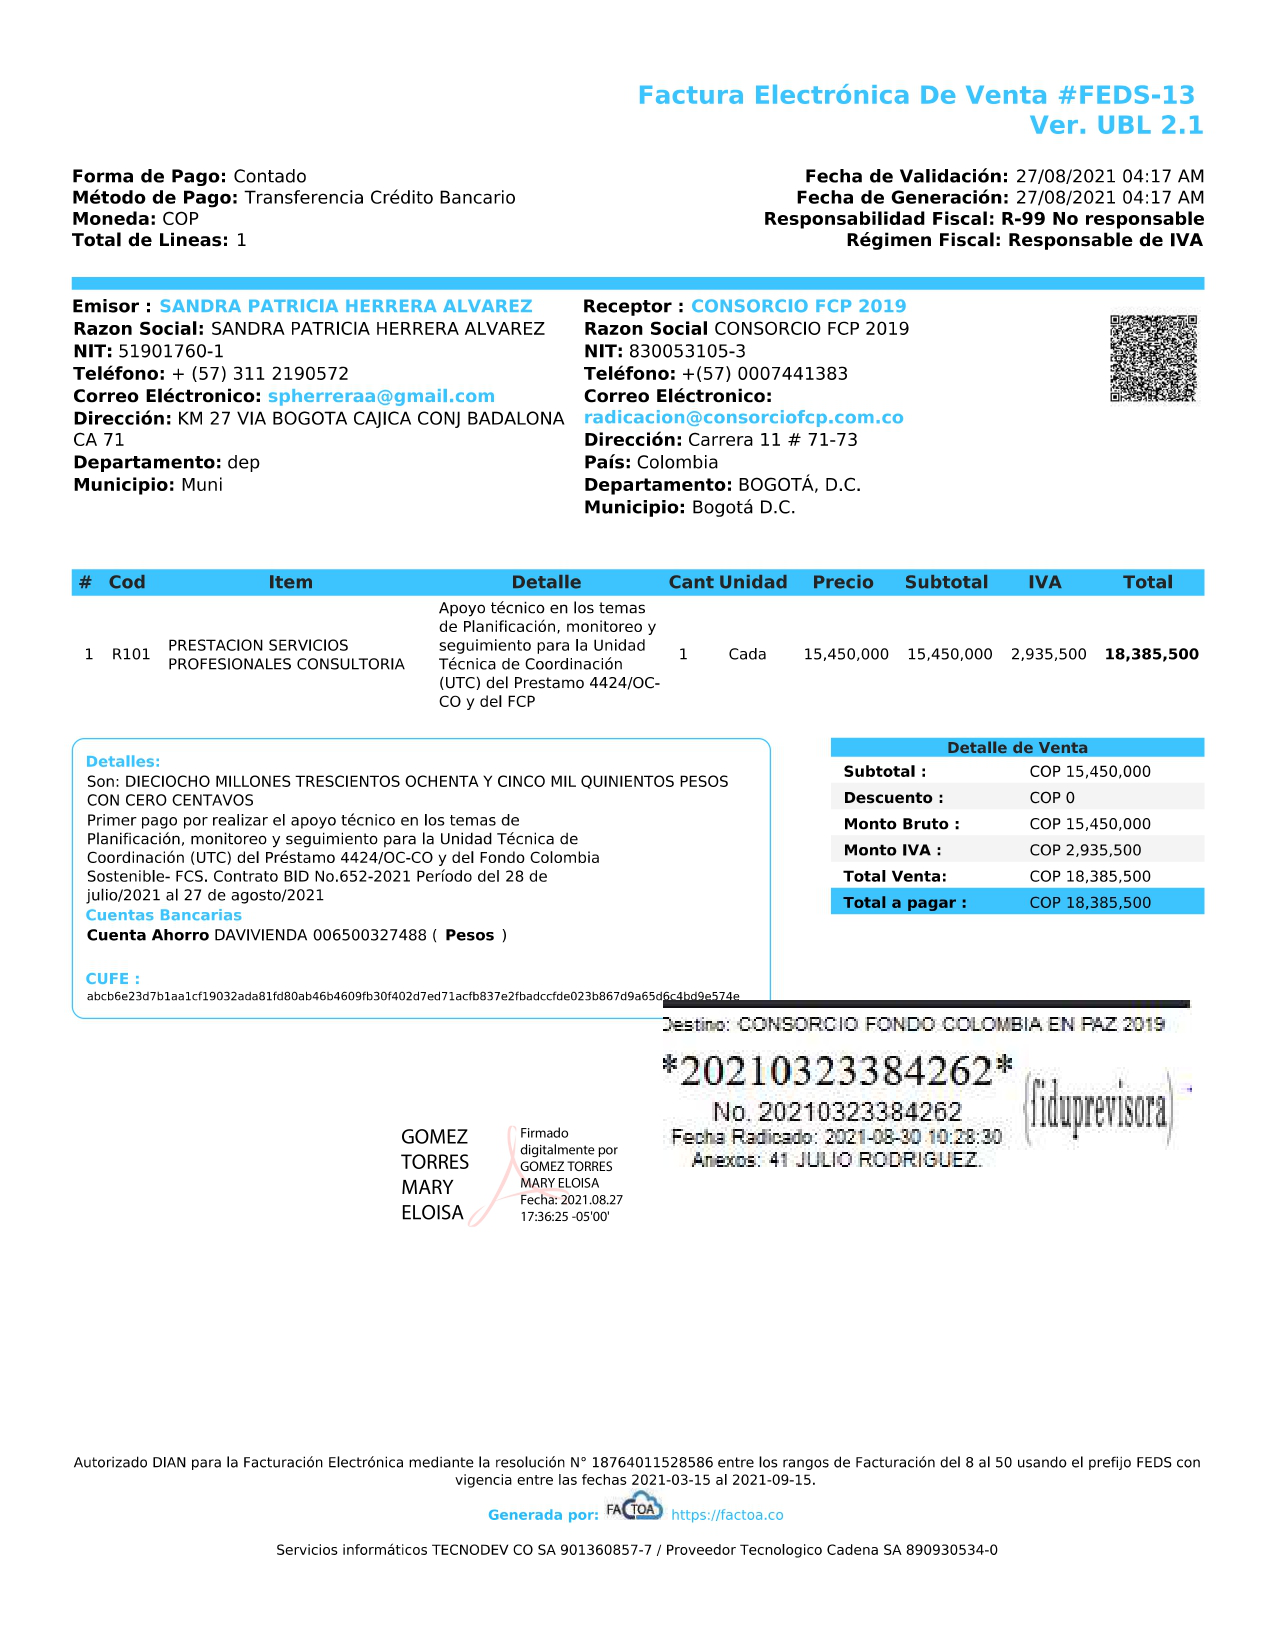

In [ ]:
PIL.Image.open(str(facturas[1]))

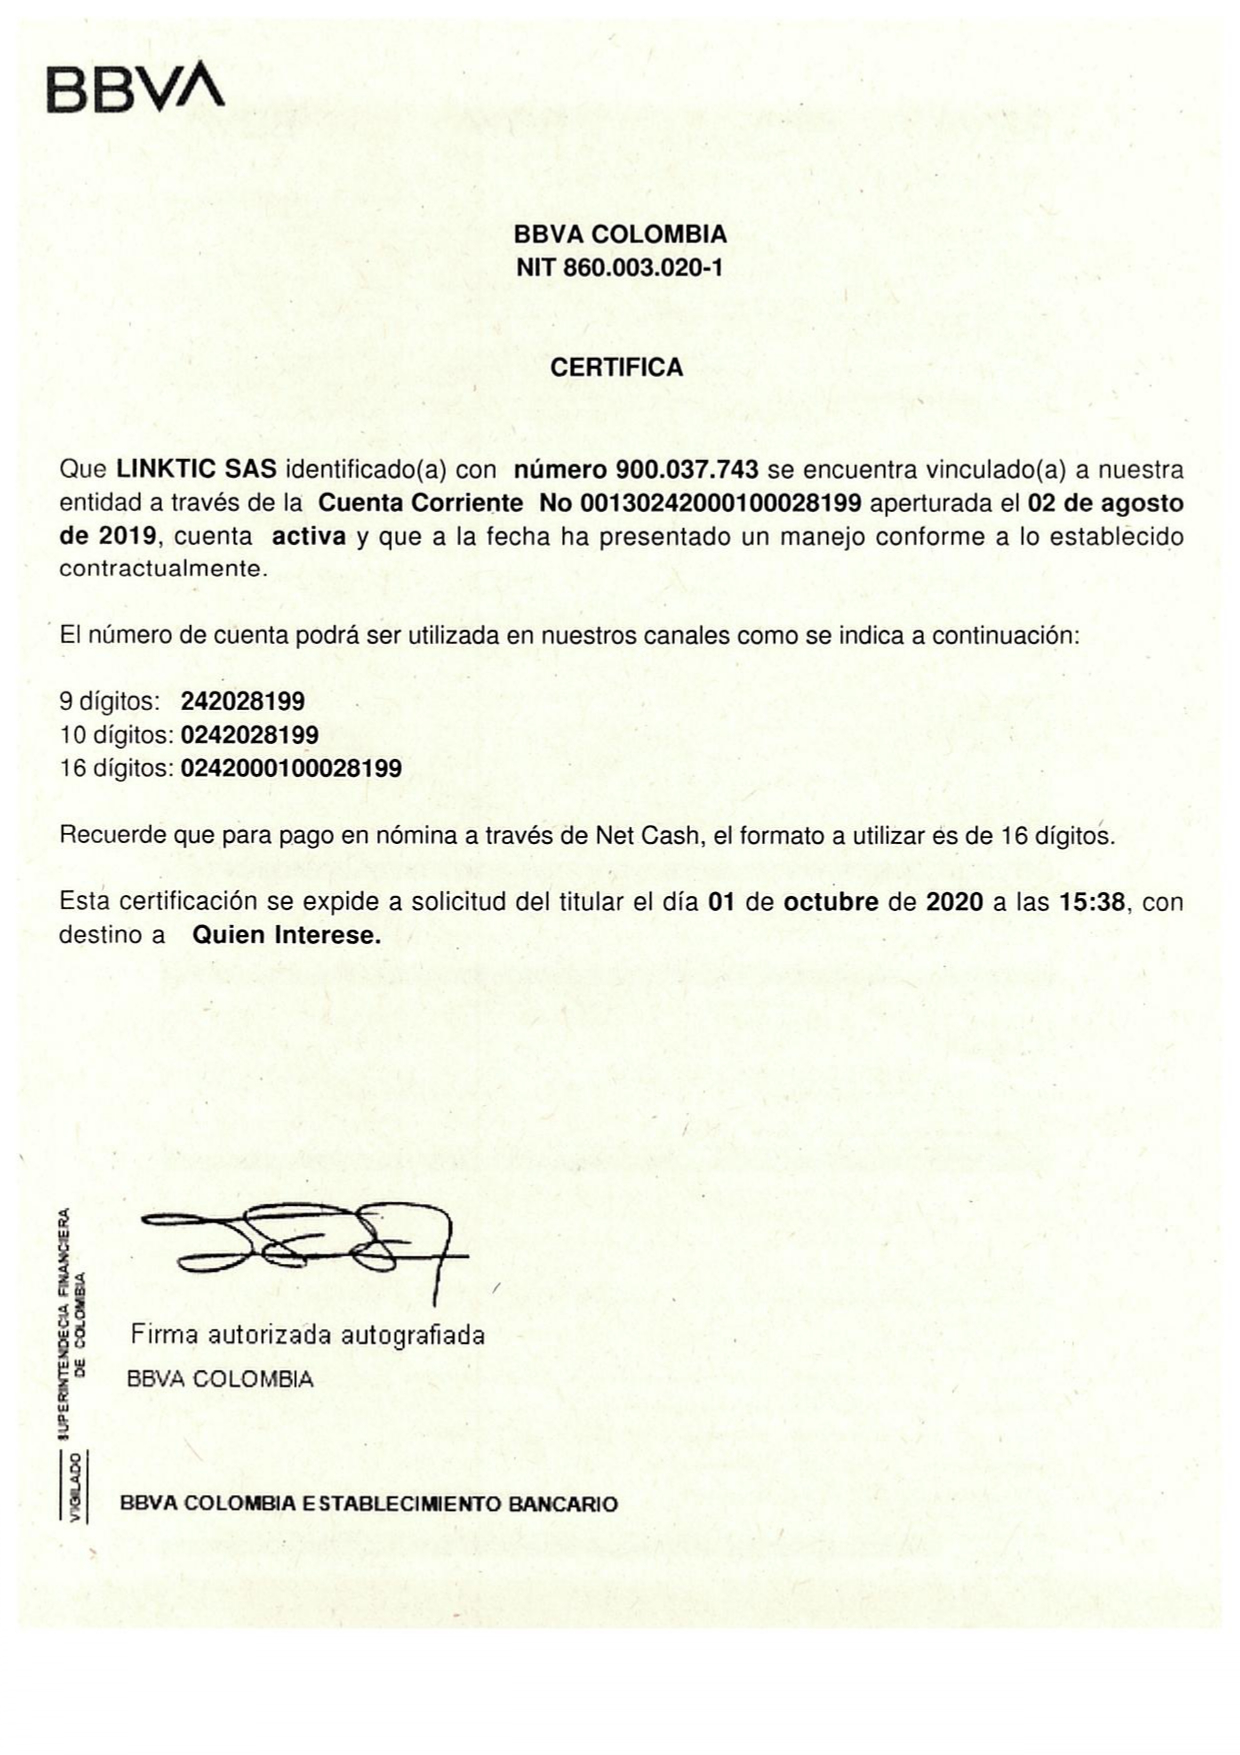

In [ ]:
certificaciones = list(data_dir.glob('cert/*'))
PIL.Image.open(str(certificaciones[0]))

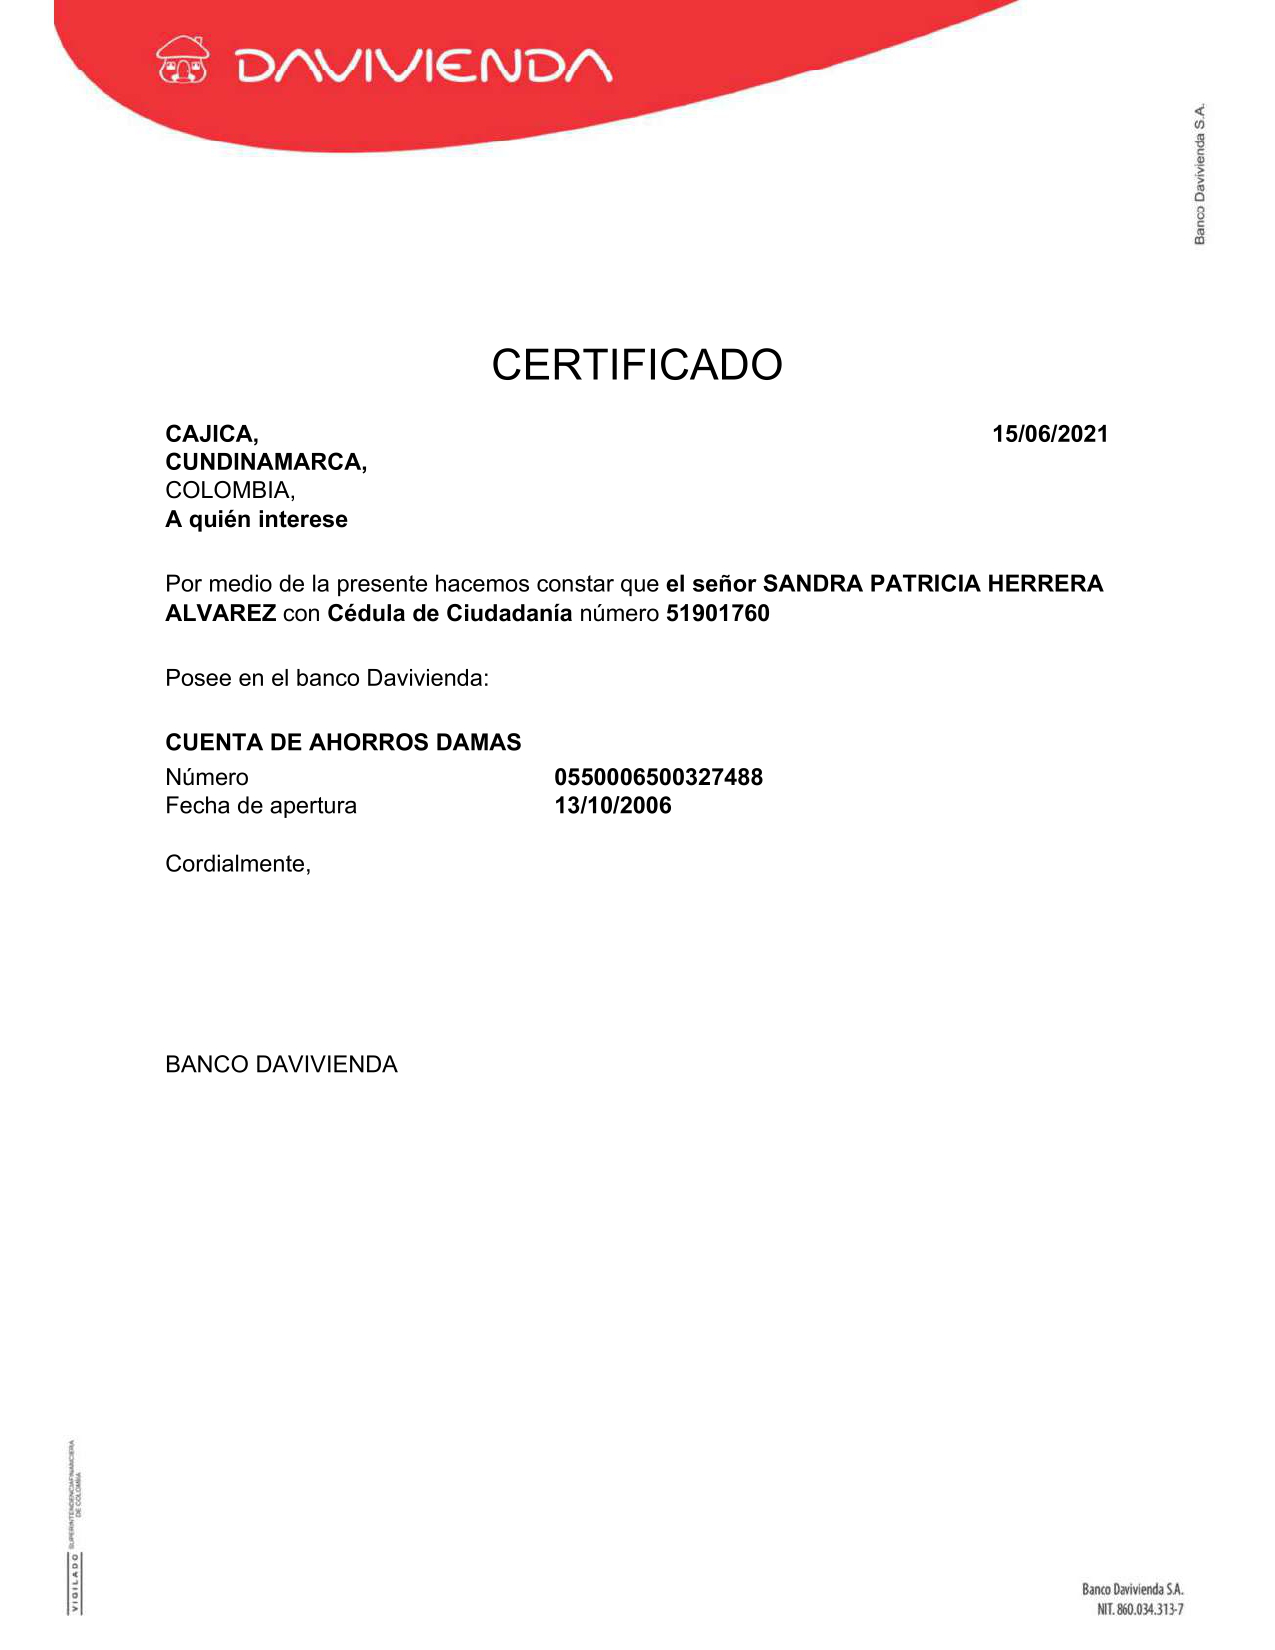

In [ ]:
PIL.Image.open(str(certificaciones[1]))

**2.   Crear el conjunto de datos de entrenamiento y validación**



In [ ]:
batch_size = 32
img_height = 299
img_width = 232

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 2 classes.
Using 64 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 2 classes.
Using 16 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)


['cert', 'fact']


**Visualización de datos**

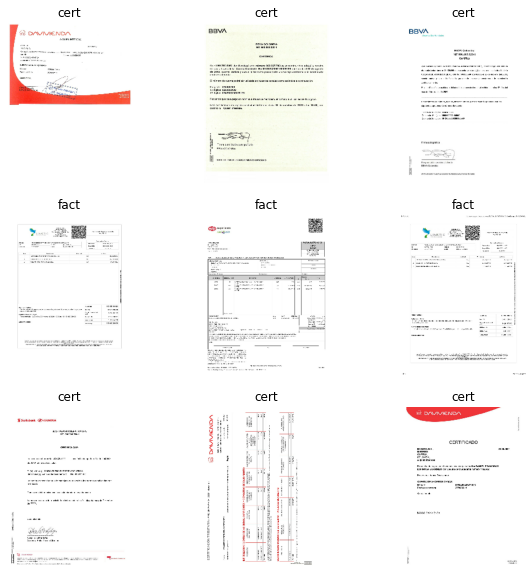

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 232, 3)
(32,)


**Configurar el conjunto de datos para el rendimiento**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Estandarizar los datos**

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


**3. Crear el modelo**


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 299, 232, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 232, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 116, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 116, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 58, 64)        1

**4. Entrenar el modelo**

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 5s 2s/step - loss: 5.7193 - accuracy: 0.4844 - val_loss: 0.8119 - val_accuracy: 0.3750
Epoch 2/20
2/2 [==============================] - 4s 2s/step - loss: 1.7176 - accuracy: 0.5312 - val_loss: 0.9447 - val_accuracy: 0.6250
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 1.0211 - accuracy: 0.6719 - val_loss: 1.0721 - val_accuracy: 0.3750
Epoch 4/20
2/2 [==============================] - 4s 2s/step - loss: 0.8050 - accuracy: 0.5312 - val_loss: 0.7140 - val_accuracy: 0.3750
Epoch 5/20
2/2 [==============================] - 4s 2s/step - loss: 0.5596 - accuracy: 0.7344 - val_loss: 0.4046 - val_accuracy: 0.9375
Epoch 6/20
2/2 [==============================] - 4s 2s/step - loss: 0.4338 - accuracy: 0.8906 - val_loss: 0.3173 - val_accuracy: 0.9375
Epoch 7/20
2/2 [==============================] - 4s 2s/step - loss: 0.2779 - accuracy: 0.9844 - val_loss: 0.2749 - val_accuracy: 0.9375
Epoch 8/20
2/2 [=========================

**5. Resultados del entrenamiento**

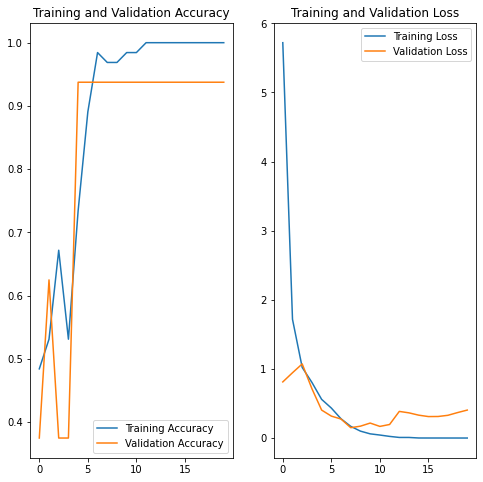

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predecir**

Se debe cargar el archivo Img_prediccion_page-0001.jpg

In [ ]:
img = tf.keras.utils.load_img('/content/Img_prediccion_page-0001.jpg', target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Es muy probable que esta imagen pertenezca a {} con un  {:.2f} procentaje de confianza"
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

Es muy probable que esta imagen pertenezca a fact con un  100.00 procentaje de confianza
